# Problem statement

The very first step in any project is to define the problem and list down the requirements to fulfil the task.
The problem I will be working on is collecting and analyzing the content in news articles from the internet.

I will follow these listed steps to solve my problem:
- Getting the data
- Cleaning the data
- Organizing the data
- Exploratory Data Analysis
- Topic Modeling

### Importing useful libraries

In [1]:

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import pickle
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from pandas import DataFrame
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction import text
from sklearn.decomposition import LatentDirichletAllocation


# Getting the data
I have used web-scraping to collect information from different articles of the same news reporter company i.e. NYTimes. I listed urls of number of articles of different categories and I will try to predict topic for these articles.


## Web Scraping

Web scraping is a way to collect data from different websities on the internet.

In [2]:
list_of_urls=['https://www.nytimes.com/2020/08/24/us/politics/kellyanne-conway-leaving-white-house.html',
              'https://www.nytimes.com/article/republicans-voting-for-biden-not-trump.html',
              'https://www.nytimes.com/2020/08/21/climate/havard-board-climate-change.html',
              'https://www.nytimes.com/2020/08/20/climate/greenland-ice-loss-climate-change.html?name=styln-climate&region=TOP_BANNER&variant=1_Show&block=storyline_menu_recirc&action=click&pgtype=Article&impression_id=eca81df0-e634-11ea-861b-cbae08a02a29',
             'https://www.nytimes.com/2020/08/03/technology/personaltech/google-pixel-4a-review.html',
             'https://www.nytimes.com/2020/06/24/technology/personaltech/family-history-genealogy-online.html',
             'https://www.nytimes.com/2020/08/20/movies/horror-streaming-sevices.html?action=click&pgtype=Article&state=default&module=STYLN_pharmacy_components&region=TOP_BANNER&context=at_home_menu',
              'https://www.nytimes.com/2020/08/22/business/economy/dejoy-postmaster-general-trump-mnuchin.html',
              'https://www.nytimes.com/article/stimulus-unemployment-payment-benefi.html',
              'https://www.nytimes.com/2020/07/29/sports/ncaabasketball/lou-henson-dead.html',
              'https://www.nytimes.com/2020/07/30/sports/ncaabasketball/college-basketball-recruiting.html',
              'https://www.nytimes.com/2020/08/13/sports/ncaa-senate-athletes-bill-of-rights.html',
              'https://www.nytimes.com/2020/08/24/well/family/young-adults-mental-health-pandemic.html',
              'https://www.nytimes.com/2020/08/24/well/live/breast-cancer-prevention.html',
              'https://www.nytimes.com/2020/08/19/well/move/e-bike-safety-exercise.html',
              'https://www.nytimes.com/2020/08/24/movies/shyamalan-tom-cruise.html'
             ]

def get_data_from_url(list_of_urls):
    text_from_articles=[]
    for url in list_of_urls:          
        page = requests.get(url).text
        soup = BeautifulSoup(page, "lxml")
        text = [p.text for p in soup.find_all(class_="css-1fanzo5 StoryBodyCompanionColumn")]
        text=' '.join(text)
        
        text_from_articles.append(text)
    return text_from_articles
        
              

In [3]:
text_from_articles=get_data_from_url(list_of_urls)

In [4]:
len(text_from_articles)

16

In [5]:
#writing text into a csv files
import csv
with open('newsarticles_data.csv', 'w', newline='',encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Text from article"])
    for article in text_from_articles:
        writer.writerow([article])

In [6]:
df=pd.read_csv('newsarticles_data.csv')
df.head()

,Text from article
0,"Kellyanne Conway, President Trump’s counselor ..."
1,Follow our latest coverage of the Biden vs. Tr...
2,"Bucking tradition, a group of climate activist..."
3,"Greenland lost a record amount of ice in 2019,..."
4,People generally adore Google for bringing use...


# Cleaning the data

Cleaning the data is the most important step as it helps to simplify data for computer as well as reduce the computation time. It also ensures that we aren't inserting garbage as the input.

When dealing with text, cleaning involves folling steps:
- Remove punctuation and numerical values
- Make words lover case
- Remove text which doesn't make any sense
- Tokenizing
- Removing stop words
- Lemmatization/stemming
- Parts of speech tagging etc.

In [7]:
#data cleaning
def data_cleaning(text):
    text=text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[\“\”\—]', '', text)
    text = re.sub(' +', ' ',text)
    return text
cleaned_data1=[]
for text in text_from_articles:
    cleaned_data1.append(data_cleaning(text))

In [8]:
df['cleaned data']=cleaned_data1

#### Document Term Matrix

In [9]:
#Count vectorier removes stop words and tokenize the text
cv = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
document_term_frequency = cv.fit_transform(cleaned_data1)
count_vect_df = pd.DataFrame(document_term_frequency.todense(), columns=cv.get_feature_names())
count_vect_df.to_csv('DTM.csv',encoding='utf-8')

# Exploratory Data Analysis

In this step most common words were visualized using word cloud.
The words which were not useful for topic modelling were removed.
After removal of those words, DTM is formed.

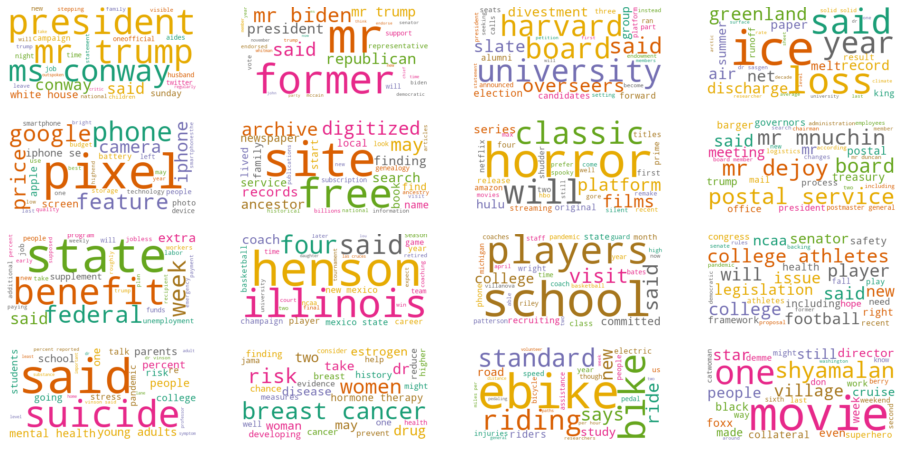

In [10]:
plt.rcParams['figure.figsize'] = [16, 8]
wc = WordCloud(background_color="white", colormap="Dark2",max_words=30,
               max_font_size=100, random_state=42)
# Create subplots for each comedian
index=0
for cleaned in df['cleaned data']:
    wc.generate(cleaned)
    plt.subplot(4, 4, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    index+=1
plt.show()

From above word cloud, some words e.g. mr, ms, dr, like, week, people,know etc will be removed.
But first, lets look at the histograms of a few most occuring words.

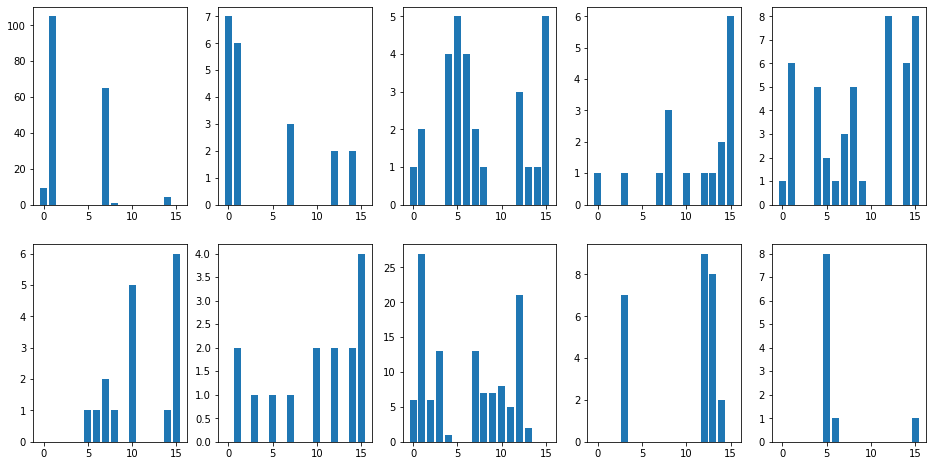

<Figure size 1440x1440 with 0 Axes>

In [11]:
import numpy as np
dtm=pd.read_csv('DTM.csv')
fig, axs = plt.subplots(2, 5)
plt.figure(figsize=(20,20))
ind=np.arange(16)
axs[0,0].bar(ind,dtm["mr"])
axs[0,1].bar(ind,dtm["ms"])
axs[0,2].bar(ind,dtm["like"])
axs[0,3].bar(ind,dtm["week"])
axs[0,4].bar(ind,dtm["people"])
axs[1,0].bar(ind,dtm["just"])
axs[1,1].bar(ind,dtm["know"])
axs[1,2].bar(ind,dtm["said"])
axs[1,3].bar(ind,dtm["dr"])
axs[1,4].bar(ind,dtm["free"])
plt.show()

#### From above histograms it can be conluded that:
- "mr" is the most occuring word in document 1
- almost all the documents include word "said"
- "know" is also present in most documents but it has low occuring frequency
- "like" is also present in all the documents

As none of the above words useful in topic modelling in our case so I will remove it.

In [12]:
#update dtm after removing stop words
from sklearn.feature_extraction import text
data=pd.read_csv('newsarticles_data.csv')
data.head()
#text=data['cleaned']
new_stop_words=['mr', 'said' ,'free' ,'ms', 'week' ,'people','just','know','dr']
stop_words = text.ENGLISH_STOP_WORDS.union(new_stop_words)
cv = CountVectorizer(max_df=0.90, min_df=2, stop_words=stop_words)
document_term_frequency = cv.fit_transform(cleaned_data1)
count_vect_df = pd.DataFrame(document_term_frequency.todense(), columns=cv.get_feature_names())
count_vect_df.to_csv('New DTM.csv',encoding='utf-8')

# Topic Modelling - Try 1
I will be using LDA for topic modelling here. After a couple of hit and trails I decided that number of topics are best distributed at n=7

In [13]:
LDA = LatentDirichletAllocation(n_components=7,random_state=42)
LDA.fit(document_term_frequency)

LatentDirichletAllocation(n_components=7, random_state=42)

Printing top 15 words for each topic

In [14]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['think', 'campaign', 'time', 'group', 'november', 'chief', 'convention', 'senator', 'democratic', 'national', 'vote', 'support', 'republican', 'president', 'trump']


THE TOP 15 WORDS FOR TOPIC #1
['stress', 'pandemic', 'risk', 'college', 'students', 'going', 'years', 'parents', 'reported', 'young', 'solid', 'health', 'percent', 'loss', 'ice']


THE TOP 15 WORDS FOR TOPIC #2
['concern', 'coronavirus', 'things', 'important', 'won', 'stephen', 'older', 'students', 'led', 'look', 'social', 'times', 'including', 'think', 'media']


THE TOP 15 WORDS FOR TOPIC #3
['woman', 'benefit', 'program', 'house', 'white', 'weeks', 'board', 'job', 'federal', 'benefits', 'state', 'university', 'states', 'risk', 'women']


THE TOP 15 WORDS FOR TOPIC #4
['great', 'coach', 'battery', 'mexico', 'players', 'state', 'price', 'year', 'left', 'ncaa', 'illinois', 'screen', 'phone', 'google', 'college']


THE TOP 15 WORDS FOR TOPIC #5
['did', 'state', 'years', 'college', 'pandemic',

# Topic Modelling - Try 2
We can see in topic number 3 woman and women state and states are being repeated. To handle this problem, words should be lemmatized.


### Lemmatizing

In [15]:
import nltk
from nltk.stem import WordNetLemmatizer
def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

 
cleaned_data2=[]
for text in cleaned_data1:
    cleaned_data2.append(lemmatizing(text))

### DTM

In [16]:
from sklearn.feature_extraction import text

new_stop_words=['mr', 'said' ,'free' ,'ms', 'week' ,'people','just','know','dr']
stop_words = text.ENGLISH_STOP_WORDS.union(new_stop_words)

cv = CountVectorizer(max_df=0.90, min_df=2, stop_words=stop_words)
document_term_frequency = cv.fit_transform(cleaned_data2)
count_vect_df = pd.DataFrame(document_term_frequency.todense(), columns=cv.get_feature_names())
count_vect_df.to_csv('DTM.csv',encoding='utf-8')

In [17]:
df['cleaned data']=cleaned_data2

### LDA

In [18]:
LDA = LatentDirichletAllocation(n_components=7,random_state=42)
LDA.fit(document_term_frequency)

LatentDirichletAllocation(n_components=7, random_state=42)

In [19]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['possible', 'daily', 'control', 'look', 'published', 'win', 'convention', 'future', 'action', 'game', 'percent', 'child', 'medium', 'john', 'rule']


THE TOP 15 WORDS FOR TOPIC #1
['government', 'superhero', 'start', 'place', 'look', 'black', 'work', 'book', 'search', 'record', 'finding', 'family', 'director', 'like', 'movie']


THE TOP 15 WORDS FOR TOPIC #2
['player', 'speed', 'activity', 'hour', 'mile', 'state', 'coach', 'illinois', 'road', 'injury', 'standard', 'study', 'say', 'risk', 'woman']


THE TOP 15 WORDS FOR TOPIC #3
['result', 'summer', 'really', 'record', 'solid', 'left', 'battery', 'photo', 'screen', 'price', 'feature', 'google', 'phone', 'loss', 'ice']


THE TOP 15 WORDS FOR TOPIC #4
['trump', 'including', 'according', 'like', 'change', 'amazon', 'governor', 'process', 'office', 'company', 'member', 'general', 'meeting', 'board', 'service']


THE TOP 15 WORDS FOR TOPIC #5
['recruiting', 'pandemic', 'job', 'board', 'program', 'coach', 'visit

Now I will label each article with a topic

In [20]:
topic_results = LDA.transform(document_term_frequency)

In [21]:
df['Topic'] = topic_results.argmax(axis=1)

In [22]:
df.head(n=16)

,Text from article,cleaned data,Topic
0,"Kellyanne Conway, President Trump’s counselor ...",kellyanne conway president trump ’ s counselor...,6
1,Follow our latest coverage of the Biden vs. Tr...,follow our latest coverage of the biden v trum...,6
2,"Bucking tradition, a group of climate activist...",bucking tradition a group of climate activist ...,5
3,"Greenland lost a record amount of ice in 2019,...",greenland lost a record amount of ice in resea...,3
4,People generally adore Google for bringing use...,people generally adore google for bringing use...,3
5,Long before the internet made it easy to share...,long before the internet made it easy to share...,1
6,While some people escape into big adventure mo...,while some people escape into big adventure mo...,4
7,"WASHINGTON — In early February, Treasury Secre...",washington in early february treasury secretar...,4
8,"In early August, President Trump declared a pl...",in early august president trump declared a pla...,5
9,"Lou Henson, who led New Mexico State and the U...",lou henson who led new mexico state and the un...,2


### We can also assign keywords manually instead of topic number for each article